In [ ]:
%pip install statsmodels

In [1]:
%matplotlib inline

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 파일들이 있는 폴더 경로
folder_path = 'C:/Users/mumu1/Desktop/project_movie_data/project_dataset'

# 파일 이름을 변수에 할당
o_df_customers = pd.read_csv(os.path.join(folder_path, 'olist_customers_dataset.csv'), encoding='ISO-8859-1')
o_df_geolocation = pd.read_csv(os.path.join(folder_path, 'olist_geolocation_dataset.csv'), encoding='ISO-8859-1')
o_df_order_items = pd.read_csv(os.path.join(folder_path, 'olist_order_items_dataset.csv'), encoding='ISO-8859-1')
o_df_order_payments = pd.read_csv(os.path.join(folder_path, 'olist_order_payments_dataset.csv'), encoding='ISO-8859-1')
o_df_order_reviews = pd.read_csv(os.path.join(folder_path, 'olist_order_reviews_dataset.csv'), encoding='ISO-8859-1')
o_df_products = pd.read_csv(os.path.join(folder_path, 'olist_products_dataset.csv'), encoding='ISO-8859-1')
o_df_sellers = pd.read_csv(os.path.join(folder_path, 'olist_sellers_dataset.csv'), encoding='ISO-8859-1')
o_df_product_category_name_translation = pd.read_csv(os.path.join(folder_path, 'product_category_name_translation.csv'), encoding='utf-8-sig')
o_df_orders = pd.read_csv(os.path.join(folder_path, 'olist_orders_dataset.csv'), encoding='ISO-8859-1')

print("✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.")

# 카피본 생성
df_customers = o_df_customers.copy()
df_geolocation = o_df_geolocation.copy()
df_order_items = o_df_order_items.copy()
df_order_payments = o_df_order_payments.copy()
df_order_reviews = o_df_order_reviews.copy()
df_products = o_df_products.copy()
df_sellers = o_df_sellers.copy()
df_product_category_name_translation = o_df_product_category_name_translation.copy()
df_order = o_df_orders.copy()

✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.


In [ ]:
# 분석 대상 데이터프레임 딕셔너리
dfs = {
    "customers": df_customers,
    "geolocation": df_geolocation,
    "order_items": df_order_items,
    "order_payments": df_order_payments,
    "order_reviews": df_order_reviews,
    "orders": ,
    "products": df_products,
    "sellers": df_sellers,
    "product_category": df_product_category_name_translation
}

# 0, 음수 비율 + IQR 이상치 탐색 함수
def check_data_quality(df, name):
    print(f"\n===== {name} =====")
    num_cols = df.select_dtypes(include="number").columns
    if len(num_cols) == 0:
        print("수치형 컬럼 없음")
        return
    for col in num_cols:
        total = len(df)

        # 0 / 음수 비율
        zero_ratio = (df[col] == 0).sum() / total * 100
        neg_ratio = (df[col] < 0).sum() / total * 100

        # IQR 이상치 비율
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outlier_ratio = ((df[col] < lower) | (df[col] > upper)).sum() / total * 100

        # 출력
        if zero_ratio > 0 or neg_ratio > 0 or outlier_ratio > 0:
            print(f"- {col}: 0 비율={zero_ratio:.2f}%, 음수 비율={neg_ratio:.2f}%, 이상치 비율={outlier_ratio:.2f}%")

# 실행
for name, df in dfs.items():
    check_data_quality(df, name)



===== customers =====

===== geolocation =====
- geolocation_lat: 0 비율=0.00%, 음수 비율=99.87%, 이상치 비율=16.82%
- geolocation_lng: 0 비율=0.00%, 음수 비율=100.00%, 이상치 비율=4.23%

===== order_items =====
- order_item_id: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=12.41%
- price: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=7.48%
- freight_value: 0 비율=0.34%, 음수 비율=0.00%, 이상치 비율=10.77%

===== order_payments =====
- payment_sequential: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=4.36%
- payment_installments: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=6.08%
- payment_value: 0 비율=0.01%, 음수 비율=0.00%, 이상치 비율=7.68%

===== order_reviews =====
- review_score: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=14.69%

===== orders =====
수치형 컬럼 없음

===== products =====
- product_name_lenght: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=0.88%
- product_description_lenght: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=6.31%
- product_photos_qty: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=2.58%
- product_weight_g: 0 비율=0.01%, 음수 비율=0.00%, 이상치 비율=13.81%
- product_length_cm: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=4.19%
- pr

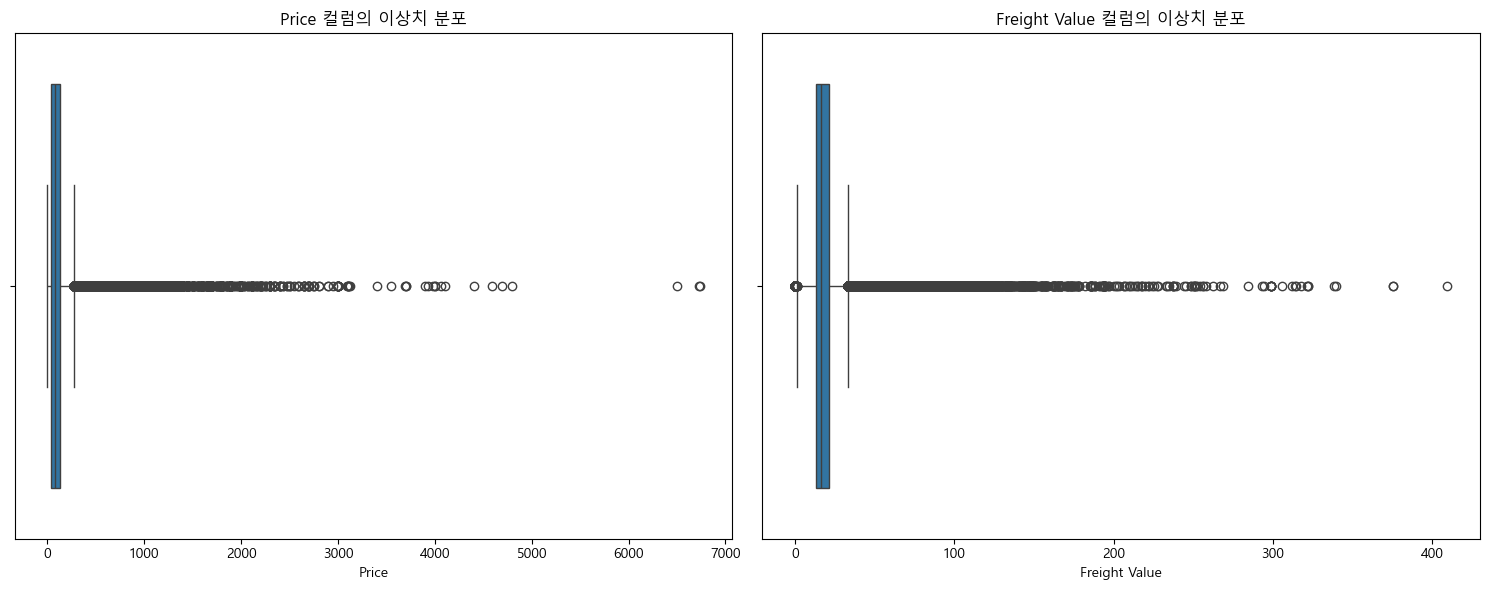

In [ ]:
# 이상치 확인: order_item['price'],['fight_value]: 시각화
# 고가의 구매제품 존재, 
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. price 컬럼의 상자 그림
sns.boxplot(x=df_order_items['price'], ax=axes[0])
axes[0].set_title('Price 컬럼의 이상치 분포')
axes[0].set_xlabel('Price')

# 2. freight_value 컬럼의 상자 그림
sns.boxplot(x=df_order_items['freight_value'], ax=axes[1])
axes[1].set_title('Freight Value 컬럼의 이상치 분포')
axes[1].set_xlabel('Freight Value')

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

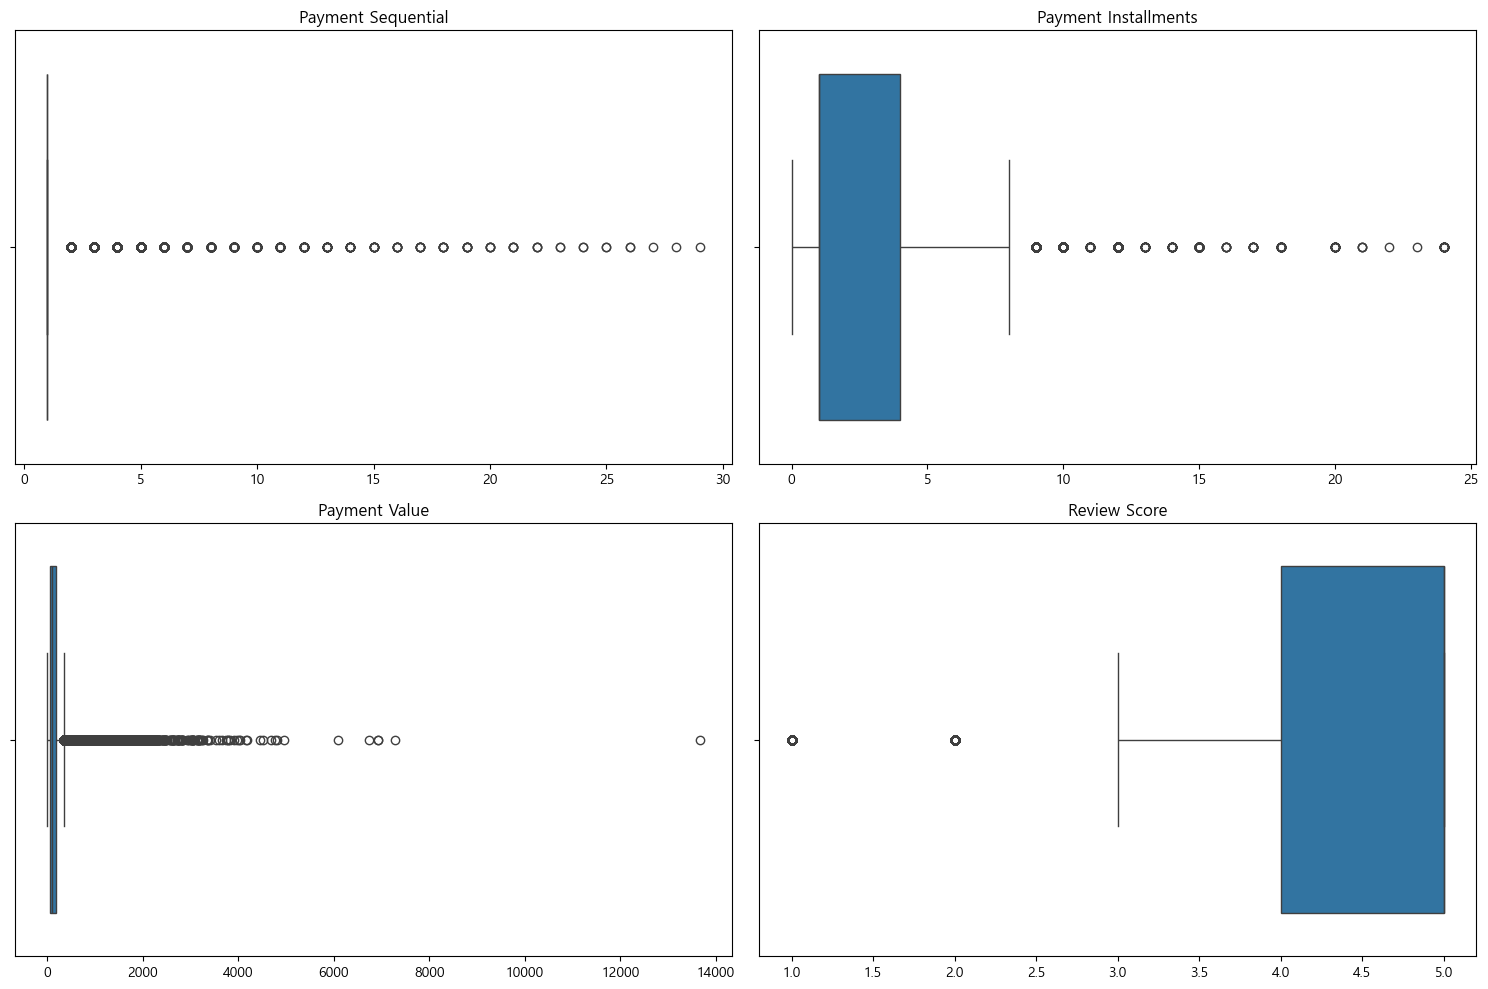

In [ ]:
# 이상치 시각화: 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. payment_sequential
sns.boxplot(x=df_order_payments['payment_sequential'], ax=axes[0, 0])
axes[0, 0].set_title('Payment Sequential')
axes[0, 0].set_xlabel('')

# 2. payment_installments
sns.boxplot(x=df_order_payments['payment_installments'], ax=axes[0, 1])
axes[0, 1].set_title('Payment Installments')
axes[0, 1].set_xlabel('')

# 3. payment_value
sns.boxplot(x=df_order_payments['payment_value'], ax=axes[1, 0])
axes[1, 0].set_title('Payment Value')
axes[1, 0].set_xlabel('')

# 4. review_score
sns.boxplot(x=df_order_reviews['review_score'], ax=axes[1, 1])
axes[1, 1].set_title('Review Score')
axes[1, 1].set_xlabel('')

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [ ]:
# payment_sequential 이상치 확인

# payment_sequential = 29 인 주문 찾기
# seq_29_orders = df_order_payments[df_order_payments['payment_sequential'] == 29]['order_id'].unique()
# print("payment_sequential=29 주문 수:", len(seq_29_orders))

# 해당 주문 상세 결제 내역 확인
# df_seq_29 = df_order_payments[df_order_payments['order_id'].isin(seq_29_orders)]
# df_seq_29 = df_seq_29.sort_values(['order_id','payment_sequential'])
# print(df_seq_29.head(20))

# 1) payment_sequential ≥ 10인 주문 ID 추출
hi_seq_orders = (
    df_order_payments.loc[df_order_payments["payment_sequential"] >= 10, "order_id"]
    .unique()
)

# 2) 해당 주문들의 결제 상세 내역 추출
hi_seq_details = (
    df_order_payments[df_order_payments["order_id"].isin(hi_seq_orders)]
    .copy()
)

# 3) 결제ID 단위 그룹핑 (order_id + payment_sequential)
grouped_by_payment = (
    hi_seq_details
    .groupby(["order_id", "payment_sequential"], as_index=False)
    .agg(
        payment_type=("payment_type", "first"),
        installments=("payment_installments", "first"),
        value_sum=("payment_value", "sum"),
        record_count=("payment_value", "count")
    )
    .sort_values(["order_id", "payment_sequential"])
)

print("=== 결제ID 단위 그룹핑 (상위 20행) ===")
print(grouped_by_payment.head(20))

# 4) 주문 단위 요약 (결제 건수, 합계)
summary_by_order = (
    grouped_by_payment
    .groupby("order_id", as_index=False)
    .agg(
        payments_cnt=("payment_sequential", "max"),
        payment_sum=("value_sum", "sum")
    )
    .sort_values("payments_cnt", ascending=False)
)

print("\n=== 주문 단위 요약 (Top 10) ===")
print(summary_by_order.head(10))

=== 결제ID 단위 그룹핑 (상위 20행) ===
                            order_id  payment_sequential payment_type  \
0   0bbb3f7791a87d0307555e57da3a1ff1                   1  credit_card   
1   0bbb3f7791a87d0307555e57da3a1ff1                   2      voucher   
2   0bbb3f7791a87d0307555e57da3a1ff1                   3      voucher   
3   0bbb3f7791a87d0307555e57da3a1ff1                   4      voucher   
4   0bbb3f7791a87d0307555e57da3a1ff1                   5      voucher   
5   0bbb3f7791a87d0307555e57da3a1ff1                   6      voucher   
6   0bbb3f7791a87d0307555e57da3a1ff1                   7      voucher   
7   0bbb3f7791a87d0307555e57da3a1ff1                   8      voucher   
8   0bbb3f7791a87d0307555e57da3a1ff1                   9      voucher   
9   0bbb3f7791a87d0307555e57da3a1ff1                  10      voucher   
10  0bbb3f7791a87d0307555e57da3a1ff1                  11      voucher   
11  1a611328643ae11146ba09a4425d2e12                   1  credit_card   
12  1a611328643ae11146

In [3]:
# 8개 데이터프레임의 결측값 분석
def check_missing(dfs, df_names):
    for df, name in zip(dfs, df_names):
        print(f"\n📊 {name} 데이터프레임 결측값 분석")
        
        missing_info = df.isnull().sum()
        m_pct = (missing_info / len(df)) * 100
        
        if missing_info.sum() == 0:
            print("✅ 결측값 없음. 완전")
        else:
            print("⚠️ 결측치 존재")
            missing_sum = pd.DataFrame({
                '결측수': missing_info,
                '결측율(%)': m_pct,
            }).round(2)
            missing_sum = missing_sum[missing_sum['결측수'] > 0]
            display(missing_sum)

# 사용 예시
original_dfs = [ 
    o_df_customers, o_df_geolocation, o_df_order_items,
    o_df_order_payments, o_df_order_reviews, o_df_products,
    o_df_sellers, o_df_product_category_name_translation,
]

df_names = [
    "customers", "geolocation", "order_items",
    "order_payments", "order_reviews", "products",
    "sellers", "product_category_name_translation",
]

check_missing(original_dfs, df_names)


📊 customers 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 geolocation 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_items 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_payments 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_reviews 데이터프레임 결측값 분석
⚠️ 결측치 존재


,결측수,결측율(%)
review_comment_title,87656,88.34
review_comment_message,58247,58.70



📊 products 데이터프레임 결측값 분석
⚠️ 결측치 존재


,결측수,결측율(%)
product_category_name,610,1.85
product_name_lenght,610,1.85
product_description_lenght,610,1.85
product_photos_qty,610,1.85
product_weight_g,2,0.01
product_length_cm,2,0.01
product_height_cm,2,0.01
product_width_cm,2,0.01



📊 sellers 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 product_category_name_translation 데이터프레임 결측값 분석
✅ 결측값 없음. 완전


# 전처리

In [4]:
# df_products 

# 결측치: 삭제
# 이상치: 음수 없음, 0 삭제

# df_products.info() # 32951

# 결측치가 있는 모든 행 삭제
df_products = df_products.dropna()

# 결측치 삭제 후 DataFrame 출력
print("결측치 삭제 후 DataFrame:")
print(df_products.info())
print("-" * 30)

# 결측치 삭제 후 결측치 수 확인
print("결측치 삭제 후 결측치 개수:")
print(df_products.isnull().sum())

# df_products.describe()

# 마이너스 값 없음
# 0값을 확인할 열 목록
zero_check_columns = [
    'product_name_lenght',
    'product_description_lenght',
    'product_photos_qty',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm'
]

# 각 열의 0값 비율 계산
zero_ratios = (df_products[zero_check_columns] == 0).mean() * 100

print("각 열의 0값 비율 (%):")
print(zero_ratios)

# 'product_weight_g' 열의 0값을 갖는 행을 삭제
df_products_cleaned = df_products[df_products['product_weight_g'] != 0]

# 'product_weight_g' 열에서 0이 모두 삭제되었는지 확인
print("'product_weight_g' 열의 0값 개수:")
print((df_products_cleaned['product_weight_g'] == 0).sum())

결측치 삭제 후 DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 32340 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32340 non-null  object 
 1   product_category_name       32340 non-null  object 
 2   product_name_lenght         32340 non-null  float64
 3   product_description_lenght  32340 non-null  float64
 4   product_photos_qty          32340 non-null  float64
 5   product_weight_g            32340 non-null  float64
 6   product_length_cm           32340 non-null  float64
 7   product_height_cm           32340 non-null  float64
 8   product_width_cm            32340 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB
None
------------------------------
결측치 삭제 후 결측치 개수:
product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qt

In [6]:
# 이상치 탐지 
df_order_items.describe() # 음수 없음

# 0값 탐지
df_combined_outliers = df_order_items[(df_order_items['price'] == 0) | (df_order_items['freight_value'] == 0)]
print(len(df_combined_outliers))

# 결측률 확인
zero_rate = (df_order_items[['price','freight_value']] == 0).mean()
print(zero_rate)

# 0인 값 삭제
df_order_items = df_order_items[(df_order_items['price'] != 0) & (df_order_items['freight_value'] != 0)]

# 0이 모두 삭제되었는지 확인
print("df_order_items 0값 개수:")
print((df_order_items['freight_value'] == 0).sum())

383
price            0.0000
freight_value    0.0034
dtype: float64
df_order_items 0값 개수:
0


📌 피어슨 상관계수:
                   price  freight_value
price          1.000000       0.414204
freight_value  0.414204       1.000000

📌 스피어맨 상관계수:
                  price  freight_value
price          1.00000        0.43419
freight_value  0.43419        1.00000


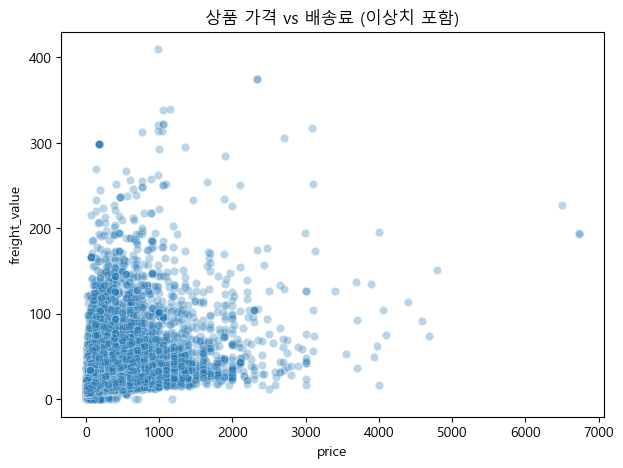

전체 데이터 행 수: 112650
IsolationForest 모델이 탐지한 이상치 개수: 1127
이상치 비율: 1.0004438526409232 %


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,outlier,is_outlier
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1,0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1,0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1,0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1,0
...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,1,0
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,1,0
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,1,0
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,1,0


In [ ]:
# df_order_items 가격과 배송료 상관관계

# 1) 기본 상관관계 확인
corr_pearson = df_order_items[['price','freight_value']].corr(method='pearson')
corr_spearman = df_order_items[['price','freight_value']].corr(method='spearman')

print("📌 피어슨 상관계수:\n", corr_pearson)
print("\n📌 스피어맨 상관계수:\n", corr_spearman)

# 2) 산점도 (이상치 포함)
plt.figure(figsize=(7,5))
sns.scatterplot(x='price', y='freight_value', data=df_order_items, alpha=0.3)
plt.title("상품 가격 vs 배송료 (이상치 포함)")
plt.show()

# 3) IsolationForest로 이상치 탐지
iso = IsolationForest(contamination=0.01, random_state=42)
df_order_items['outlier'] = iso.fit_predict(df_order_items[['price','freight_value']])

# -1 = 이상치, 1 = 정상
print("전체 데이터 행 수:", len(df_order_items))
print("IsolationForest 모델이 탐지한 이상치 개수:", (df_order_items['outlier']==-1).sum())
print("이상치 비율:", (df_order_items['outlier']==-1).mean()*100, "%")

# 삭제하지 않고 별도 태그로 나눠서 관리
# df_order_items (원본) → 이상치 포함 전체 데이터
# df_order_items[df_order_items["is_outlier"] == 0] → 이상치 제거 데이터
# 추후 “전체 평균 배송비” vs “이상치 제외 평균 배송비” 분석 예정
df_order_items["is_outlier"] = (df_order_items["outlier"] == -1).astype(int)

In [7]:
'''
df_order_reviews 

1. 데이터 상황 요약
review_comment_title: 결측치 88% → 고객 대부분이 제목은 아예 작성하지 않음.
review_comment_message: 결측치 59% → 절반 이상이 코멘트를 남기지 않음.
제목 없이 내용 쓴 리뷰: 88-59= 29%
'''

# --- 결측치 대체: 'No Comment'로 치환 ---
df_order_reviews["review_comment_title"] = df_order_reviews["review_comment_title"].fillna("No Comment_title")
df_order_reviews["review_comment_message"] = df_order_reviews["review_comment_message"].fillna("No Comment_message")

# --- 리뷰 작성 여부 플래그 생성 ---
df_order_reviews["has_message"] = df_order_reviews["review_comment_message"].apply(lambda x: 0 if x == 'No Comment' else 1)
df_order_reviews["has_title"] = df_order_reviews["review_comment_title"].apply(lambda x: 0 if x == 'No Comment' else 1)

# 확인
# print("📌 클리닝된 데이터프레임 (일부)")
# print(df_order_reviews.head())

print("\n--- 리뷰 작성 여부 플래그 분포 ---")
print("📌 has_message 분포")
print(df_order_reviews["has_message"].value_counts(normalize=True).round(3) * 100)
print("\n📌 has_title 분포")
print(df_order_reviews["has_title"].value_counts(normalize=True).round(3) * 100)



--- 리뷰 작성 여부 플래그 분포 ---
📌 has_message 분포
has_message
1    100.0
Name: proportion, dtype: float64

📌 has_title 분포
has_title
1    100.0
Name: proportion, dtype: float64


In [25]:
# df_order 결측치 처리: 결측률 낮음 결측치 제거

# 결측치 제거 전
print("결측치 제거 전 df_order의 정보:")
print(df_order.info())

# 결측치를 제거할 컬럼 리스트 정의
missing_value_cols = ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']

# 5% 이하 3개 컬럼의 결측치 제거
df_order = df_order.dropna(subset=missing_value_cols)

print("결측치 제거 후 df_order의 정보:")
print(df_order.info())

# 결측치 제거 후 각 열의 결측치 수 확인
print("결측치 제거 후 각 열의 결측치 수:")
print(df_order.isnull().sum())

결측치 제거 전 df_order의 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None
결측치 제거 후 df_order의 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         -------------

In [ ]:
## df_order_items 컬럼 추가
# df_order_items['The total order value'] : order_id별 총구매액
# df_order_items['Total Sales'] : 총매출

# 1. df_order_items['The total order value']  
total_price = df_order_items.groupby('order_id')['price'].transform('sum')
total_freight = df_order_items.groupby('order_id')['freight_value'].transform('sum')
df_order_items['The total order value'] = total_price + total_freight

# 2. 총매출 계산 (모든 주문총액 합계)
total_sales = df_order_items['The total order value'].sum()

# 3. 총매출을 새로운 컬럼으로 추가
# -> 각 행에 동일한 총매출 값이 들어감
df_order_items['Total Sales'] = total_sales

# 4. 특정 주문 확인 (예: 동일제품 2개 구매)
specific_order_id = '0008288aa423d2a3f00fcb17cd7d8719'
specific_order = df_order_items[df_order_items['order_id'] == specific_order_id]

# print("=== 특정 주문 상세 ===")
print(specific_order)
df_order_items.head()

                            order_id  order_item_id  \
13  0008288aa423d2a3f00fcb17cd7d8719              1   
14  0008288aa423d2a3f00fcb17cd7d8719              2   

                          product_id                         seller_id  \
13  368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   
14  368c6c730842d78016ad823897a372db  1f50f920176fa81dab994f9023523100   

    shipping_limit_date  price  freight_value  The total order value  
13  2018-02-21 02:55:52   49.9          13.37                 126.54  
14  2018-02-21 02:55:52   49.9          13.37                 126.54  


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,The total order value,Total Sales
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,72.19,20304557.35
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,259.83,20304557.35
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,216.87,20304557.35
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,25.78,20304557.35
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,218.04,20304557.35


In [12]:
# 1) merge: df_order + df_order_items = join_order_items

# df_order: 고유 order_id 96,461개
# df_order_items: 고유 order_id 98,666개
print(df_order['order_id'].nunique(), len(df_order))
print(df_order_items['order_id'].nunique(), len(df_order_items))

join_order_items = pd.merge(df_order, df_order_items, on='order_id', how='inner')

print(join_order_items.head())
# print(join_order_items.head())

96461 96461
98328 112267
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 1

In [ ]:
# 2) inner join 병합: join_order_items + df_customers = jj_order_items_cu

# 병합 전 확인 jj_order_items_cu
# # 'join_order_items'의 'customer_id' 고유값 개수 및 데이터 타입 확인
# print("\njoin_order_items의 'customer_id' 고유값 개수:", join_order_items['customer_id'].nunique())
# print("join_order_items의 'customer_id' 데이터 타입:", join_order_items['customer_id'].dtype)

# # 'df_customers'의 'customer_id' 고유값 개수 및 데이터 타입 확인
# print("\ndf_customers의 'customer_id' 고유값 개수:", df_customers['customer_id'].nunique())
# print("df_customers의 'customer_id' 데이터 타입:", df_customers['customer_id'].dtype)

# inner join 병합: join_order_items + df_customers = jj_order_items_cu
# 모든 정보를 가진 주문 데이터와 해당 고객 정보를 결합합니다.
jj_order_items_cu = pd.merge(join_order_items, df_customers, on='customer_id', how='inner')

# 병합된 데이터프레임 확인
print("병합된 데이터프레임:")
print(jj_order_items_cu)
print("\n병합된 데이터프레임 정보:")
print(jj_order_items_cu.info())

# 병합 후 'customer_id' 고유값 개수 확인
# print("\n병합 후 'customer_id' 고유값 개수:", jj_order_items_cu['customer_id'].nunique())
jj_order_items_cu.head()
# jj_order_items_cu.isnull().sum()

병합된 데이터프레임:
                                order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3       949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4       ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                  ...                               ...   
109794  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
109795  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
109796  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
109797  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
109798  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_status order_purchase_timestamp    ord

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,outlier_flag,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,1,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,1,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,1,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,1,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [ ]:
# 3) merge join_ois = jj_order_items_cu(join_order_items + df_customers) + df_sellers
join_ois = pd.merge(jj_order_items_cu, df_sellers, on='seller_id', how='inner')

# 최종 데이터프레임의 정보 확인
# print(join_ois.info())
# print(join_ois.isnull().sum())
join_ois.describe()

,order_item_id,price,freight_value,outlier_flag,customer_zip_code_prefix,seller_zip_code_prefix
count,109799.000000,109799.000000,109799.000000,109799.000000,109799.000000,109799.000000
mean,1.198390,114.787234,19.678468,0.980364,35140.749816,24512.893770
std,0.707419,135.702354,12.732295,0.197197,29908.360977,27660.473905
min,1.000000,9.990000,6.640000,-1.000000,1003.000000,1001.000000
25%,1.000000,39.900000,13.090000,1.000000,11250.000000,6429.000000
50%,1.000000,74.900000,16.280000,1.000000,24340.000000,13561.000000
75%,1.000000,134.900000,21.150000,1.000000,59065.000000,28630.000000
max,21.000000,890.000000,84.573400,1.000000,99980.000000,99730.000000


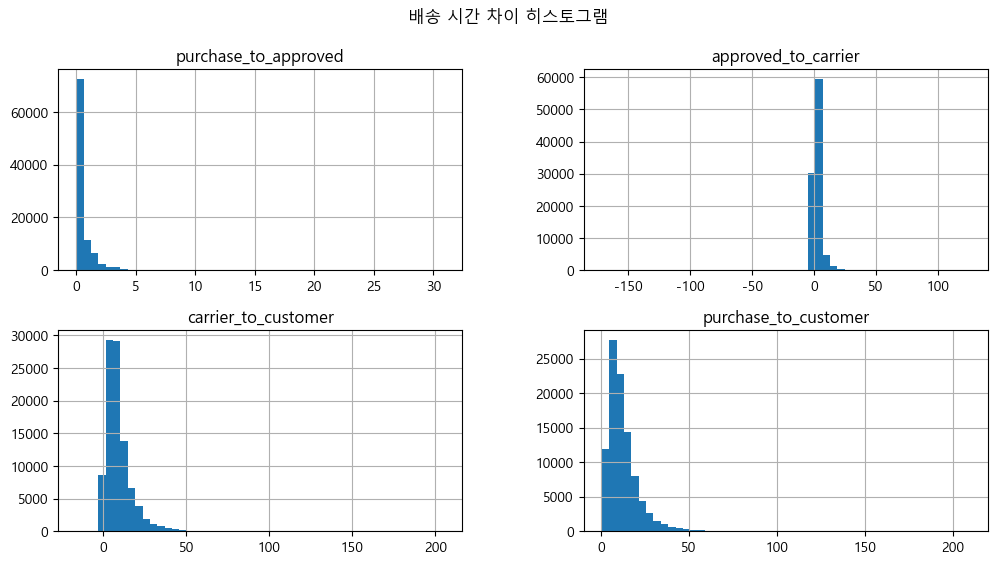

=== Z-score 기준 이상치 비율 (|Z|>3) ===
purchase_to_approved: 2.26%
approved_to_carrier: 1.92%
carrier_to_customer: 1.64%
purchase_to_customer: 1.63%

=== IQR 기준 이상치 비율 ===
purchase_to_approved: 9.26%
approved_to_carrier: 5.80%
carrier_to_customer: 5.26%
purchase_to_customer: 5.08%


In [ ]:
# df_order 이상치 탐지 시각화

# 1️⃣ 히스토그램 시각화
df_order[time_cols].hist(bins=50, figsize=(12,6))
plt.suptitle("배송 시간 차이 히스토그램")
plt.show()

# 2️⃣ 극단치 비율 계산
print("=== Z-score 기준 이상치 비율 (|Z|>3) ===")
for col in time_cols:
    z = zscore(df_order[col].dropna())
    outlier_ratio = (abs(z) > 3).mean() * 100
    print(f"{col}: {outlier_ratio:.2f}%")

# 3️⃣ IQR 기반 이상치 비율 계산
print("\n=== IQR 기준 이상치 비율 ===")
for col in time_cols:
    data = df_order[col].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    iqr_outlier_ratio = ((data < lower_bound) | (data > upper_bound)).mean() * 100
    print(f"{col}: {iqr_outlier_ratio:.2f}%")

In [26]:
# --- 이상치 플래그 추가 ---
df_order["is_outlier"] = (df_order[time_cols] < 0).any(axis=1)

# 이상치 개수 확인
print("이상치 건수:", df_order["is_outlier"].sum())

# 이상치 제외한 데이터프레임 생성
df_order_clean = df_order[~df_order["is_outlier"]].copy()

print("정제 후 데이터 크기:", df_order_clean.shape)


NameError: name 'time_cols' is not defined

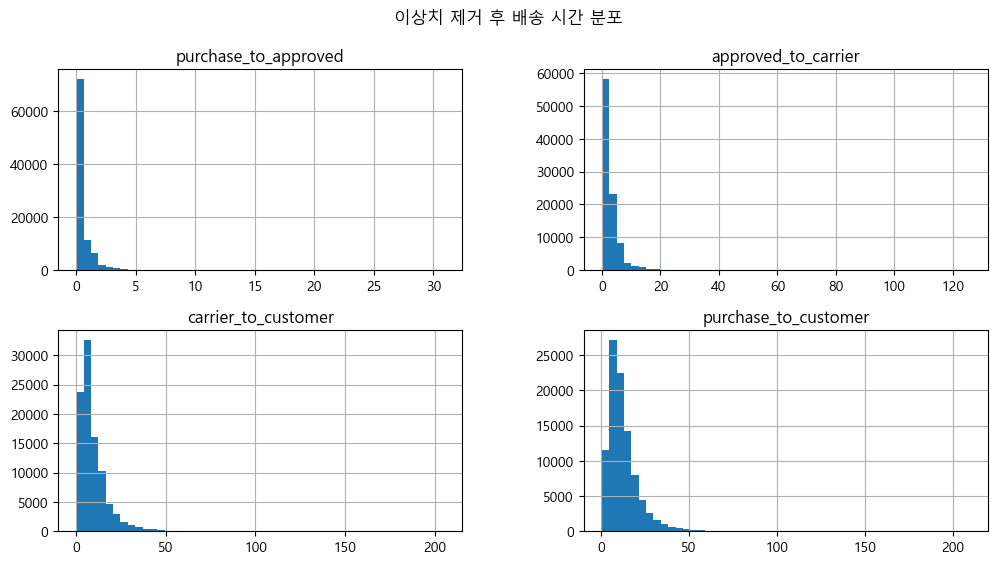

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_to_approved,approved_to_carrier,carrier_to_customer,purchase_to_customer
count,95088,95088,95088,95088,95088,95088.000000,95088.000000,95088.000000,95088.000000
mean,2017-12-31 02:58:13.884559616,2017-12-31 12:37:15.921357056,2018-01-03 09:04:07.208028416,2018-01-12 17:48:48.140701184,2018-01-23 20:52:29.318526208,0.402107,2.851982,9.364363,12.618452
min,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-04 00:00:00,0.000000,0.000174,0.000000,0.533414
25%,2017-09-12 21:57:03,2017-09-13 11:25:10.500000,2017-09-15 15:44:43.750000128,2017-09-23 16:06:47.500000,2017-10-04 00:00:00,0.008935,0.900521,4.111019,6.811930
50%,2018-01-18 02:13:42,2018-01-18 12:33:28,2018-01-22 21:30:37,2018-01-31 19:22:15,2018-02-14 00:00:00,0.014074,1.848883,7.110324,10.271175
75%,2018-05-03 18:47:43.249999872,2018-05-04 03:31:33,2018-05-07 14:19:00,2018-05-14 19:48:40.249999872,2018-05-25 00:00:00,0.564190,3.616461,12.057983,15.808166
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,30.893484,125.762569,205.190972,209.628611
std,NaN,NaN,NaN,NaN,NaN,0.796515,3.483396,8.769619,9.572024


In [ ]:
# df_order_clean
# 이상치 제거 후 배송 시간 분포 확인
df_order_clean[time_cols].hist(bins=50, figsize=(12,6))
plt.suptitle("이상치 제거 후 배송 시간 분포")
plt.show()

# 이상치 확인 후 도메인 규칙 기반 제거
df_order_clean = df_order_clean[df_order_clean['approved_to_carrier'] >= 0]
df_order_clean = df_order_clean[df_order_clean['carrier_to_customer'] >= 0]

# 기초 통계 확인
df_order_clean[time_cols].describe()

df_order_clean.describe()
# df_order_clean = df_deliverd_clean


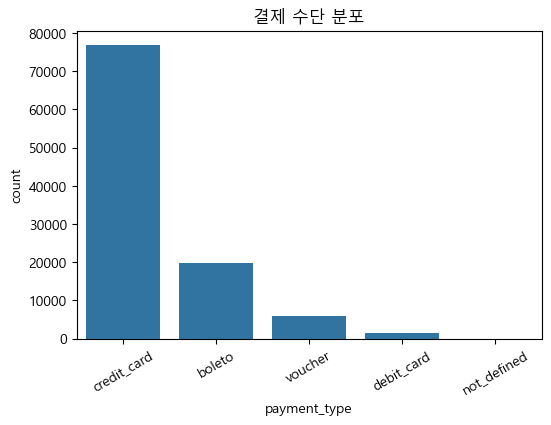


[결제 수단 비율]
payment_type
credit_card    0.739
boleto         0.190
voucher        0.056
debit_card     0.015
not_defined    0.000
Name: proportion, dtype: float64


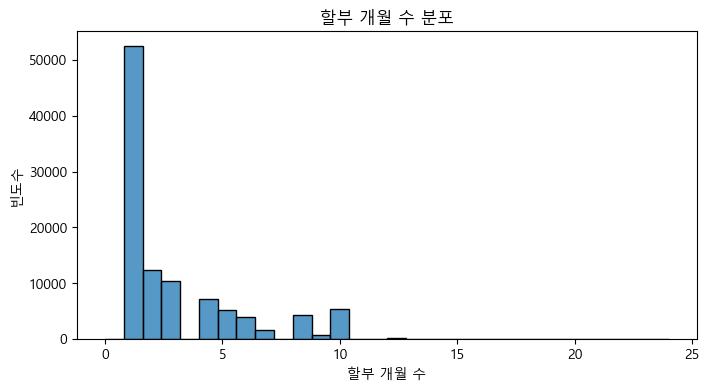


[할부 개월 수 통계]
count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64


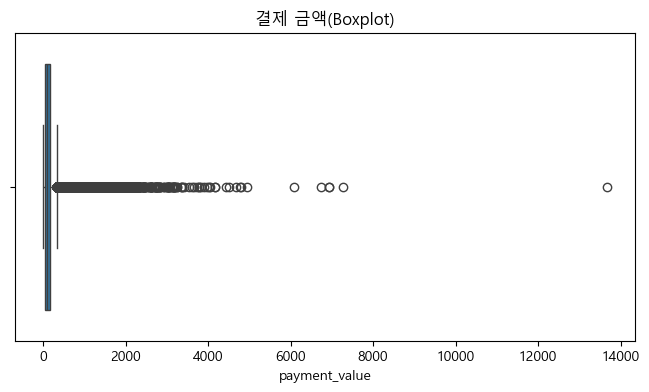

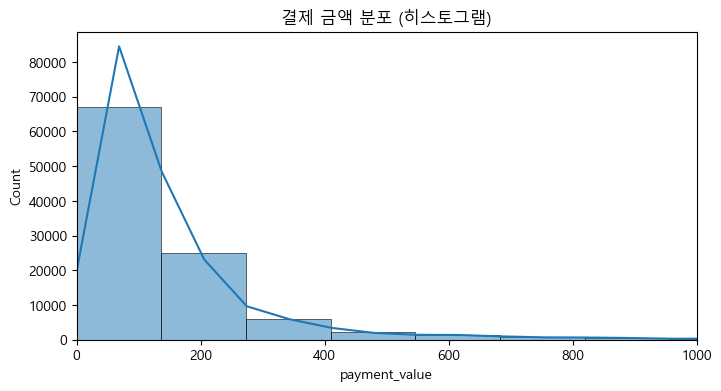


[결제 금액 통계]
count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

[결제 금액 이상치 개수] 7981 / 103886 (7.68%)


' 이상치 간주\npayment_type: 0, 음수, not_defined 제거\npayment_installments (할부 개월 수): 0(일시불)/ 음수, 24개월 초과 제거\npayment_value: 0(일시불), / 음수, Q1, Q3 기반 IQR로 극단치 검출 -> Winsorization (상한 절단)\n\n평균(Mean) = 154.1 → 극단값(고액 결제)의 영향으로 평균이 중앙값보다 큼\n최댓값 = 13,664.08 → 단 1건 정도의 초고액 결제 (전체 분포와 매우 동떨어짐)\nIQR 이상치 비율 ≈ 7.7% (7,981건) → 전체 결제의 약 8%가 극단값\n'

In [ ]:
# df_order_payments: 결측X, 이상치 탐지

# 1. payment_type 분포 확인
plt.figure(figsize=(6,4))
sns.countplot(data=o_df_order_payments, x='payment_type', order=o_df_order_payments['payment_type'].value_counts().index)
plt.title("결제 수단 분포")
plt.xticks(rotation=30)
plt.show()

print("\n[결제 수단 비율]")
print(o_df_order_payments['payment_type'].value_counts(normalize=True).round(3))

# 2. 할부 개월 수 분포
plt.figure(figsize=(8,4))
sns.histplot(o_df_order_payments['payment_installments'], bins=30, kde=False)
plt.title("할부 개월 수 분포")
plt.xlabel("할부 개월 수")
plt.ylabel("빈도수")
plt.show()

print("\n[할부 개월 수 통계]")
print(o_df_order_payments['payment_installments'].describe())

# 3. 결제 금액 분포 (payment_value)
plt.figure(figsize=(8,4))
sns.boxplot(x=o_df_order_payments['payment_value'])
plt.title("결제 금액(Boxplot)")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(o_df_order_payments['payment_value'], bins=100, kde=True)
plt.title("결제 금액 분포 (히스토그램)")
plt.xlim(0, 1000)  # 고액 결제는 따로 확인하기 위해 일단 1000 이하만 시각화
plt.show()

print("\n[결제 금액 통계]")
print(o_df_order_payments['payment_value'].describe())

# 4. 이상치 건수 확인 (IQR 방식)
Q1 = o_df_order_payments['payment_value'].quantile(0.25)
Q3 = o_df_order_payments['payment_value'].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (o_df_order_payments['payment_value'] < Q1 - 1.5*IQR) | (o_df_order_payments['payment_value'] > Q3 + 1.5*IQR)

print(f"\n[결제 금액 이상치 개수] {outlier_mask.sum()} / {len(o_df_order_payments)} ({outlier_mask.mean()*100:.2f}%)")

''' 이상치 간주
payment_type: 0, 음수, not_defined 제거
payment_installments (할부 개월 수): 0(일시불)/ 음수, 24개월 초과 제거
payment_value: 0(일시불), / 음수, Q1, Q3 기반 IQR로 극단치 검출 -> Winsorization (상한 절단)

평균(Mean) = 154.1 → 극단값(고액 결제)의 영향으로 평균이 중앙값보다 큼
최댓값 = 13,664.08 → 단 1건 정도의 초고액 결제 (전체 분포와 매우 동떨어짐)
IQR 이상치 비율 ≈ 7.7% (7,981건) → 전체 결제의 약 8%가 극단값
'''


In [ ]:
df_order_payments = o_df_order_payments
df_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [ ]:
'''
payments 이상치 라벨링 처리 -> 라벨링 df 생성: df_label_payment
installments = 0 → "일시불" 카테고리로 변환.
payment_value = 0 → "0원 결제" (ex. 쿠폰, 무료배송, 취소된 거래 등)으로 별도 라벨링.
'''
# 결제데이터 복사
df_lavel_payments = df_order_payments.copy()

# 일시불 라벨링
df_lavel_payments['installment_label'] = df_lavel_payments['payment_installments'].apply(
    lambda x: '일시불' if x == 0 else '할부'
)

# 결제금액 라벨링
df_lavel_payments['payment_label'] = df_lavel_payments['payment_value'].apply(
    lambda x: '0원결제' if x == 0 else '유료결제'
)

# 분포 확인
print(df_lavel_payments['installment_label'].value_counts())
print(df_lavel_payments['payment_label'].value_counts())

# 이상치로 보이는 데이터 일부 확인
print(df_lavel_payments[df_lavel_payments['payment_value'] == 0].head(10))

installment_label
할부     103884
일시불         2
Name: count, dtype: int64
payment_label
유료결제    103877
0원결제         9
Name: count, dtype: int64
                                order_id  payment_sequential payment_type  \
19922   8bcbe01d44d147f901cd3192671144db                   4      voucher   
36822   fa65dad1b0e818e3ccc5cb0e39231352                  14      voucher   
43744   6ccb433e00daae1283ccc956189c82ae                   4      voucher   
51280   4637ca194b6387e2d538dc89b124b0ee                   1  not_defined   
57411   00b1cb0320190ca0daa2c88b35206009                   1  not_defined   
62674   45ed6e85398a87c253db47c2d9f48216                   3      voucher   
77885   fa65dad1b0e818e3ccc5cb0e39231352                  13      voucher   
94427   c8c528189310eaa44a745b8d9d26908b                   1  not_defined   
100766  b23878b3e8eb4d25a158f57d96331b18                   4      voucher   

        payment_installments  payment_value installment_label payment_label  
19922    

# MERGE
join_order_c = df_order_clean + df_customers + df_payments + df_order_items

In [ ]:
'''
MERGE
customer 데이터 탐색: 이상치 처리 안함, 데이터 손실 최소화
customer states 컬럼: SP(상파울루 주), RJ (리우데자네이루 주)
'''
# df_order.info() #77694, 컬럼 12개
# df_customers.info() #99441 컬럼 5개

# 1. 주문 + 고객 정보 데이터 조인 (order_id 기준)
join_order_c= df_order_clean.merge(
    df_customers,
    on='customer_id',
    how='left'   # 주문은 반드시 유지, 고객 정보가 없으면 NaN
)

print(f"Merge 후 레코드 수: {len(join_order_c)}")
print(f"원본 df_order 레코드 수: {len(df_order)}")
print("고유 order_id 개수:", join_order_c['order_id'].nunique())
print("전체 order_id 대비 중복 비율:", 1 - join_order_c['order_id'].nunique() / len(join_order_c))

print("customer_city 결측치 개수:", join_order_c['customer_city'].isnull().sum())
print("customer_city 결측치 비율:", join_order_c['customer_city'].isnull().mean())

print(join_order_c.dtypes)

join_order_c['purchase_to_approved'].head()
print(join_order_c.isnull().sum())

Merge 후 레코드 수: 95088
원본 df_order 레코드 수: 96461
고유 order_id 개수: 95088
전체 order_id 대비 중복 비율: 0.0
customer_city 결측치 개수: 0
customer_city 결측치 비율: 0.0
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
purchase_to_approved                    float64
approved_to_carrier                     float64
carrier_to_customer                     float64
purchase_to_customer                    float64
is_outlier                                 bool
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
dtype: object
order_id                  

In [ ]:
# df_join_order_cp

# 3. 1번 df + df_order_payments_sum 병합
df_join_order_cp= join_order_c.merge(
    df_order_payments,
    on='order_id',
    how='left'
)

# df_join_order_cp.info()
# print(f"Merge 후 레코드 수: {len(df_join_order_cp)}")
# print(f"원본 df_order 레코드 수: {len(df_join_order_cp)}")
# print(df_join_order_cp.isnull().sum())

# 'payment_type' 컬럼에 결측치가 있는 행만 필터링
nan_rows = df_join_order_cp[df_join_order_cp['payment_type'].isnull()]

print("=== 결측치가 있는 행 ===")
print(nan_rows)

# 결측치 개수 다시 확인
print("\n=== 결측치 개수 ===")
print(nan_rows.isnull().sum())

# 'payment_type' 컬럼에 결측치가 있는 행 제거
df_join_order_cp_cleaned = df_join_order_cp.dropna(subset=['payment_type'])

# 삭제 후 데이터프레임의 행 수 확인
print(f"결측치 제거 전 행 수: {len(df_join_order_cp):,}")
print(f"결측치 제거 후 행 수: {len(df_join_order_cp_cleaned):,}")

# 결측치가 제거되었는지 다시 확인
print("\n=== 결측치 제거 후 확인 ===")
print(df_join_order_cp_cleaned.isnull().sum())

=== 결측치가 있는 행 ===
                               order_id                       customer_id  \
30708  bfbd0f9bdef84302105ad712db648a6c  86dc2ffce2dfff336de2f386a786e574   

      order_status order_purchase_timestamp   order_approved_at  \
30708    delivered      2016-09-15 12:16:38 2016-09-15 12:16:38   

      order_delivered_carrier_date order_delivered_customer_date  \
30708          2016-11-07 17:11:53           2016-11-09 07:47:38   

      order_estimated_delivery_date  purchase_to_approved  \
30708                    2016-10-04                   0.0   

       approved_to_carrier  ...  purchase_to_customer  is_outlier  \
30708            53.205035  ...             54.813194       False   

                     customer_unique_id customer_zip_code_prefix  \
30708  830d5b7aaa3b6f1e9ad63703bec97d23                    14600   

              customer_city customer_state payment_sequential  payment_type  \
30708  sao joaquim da barra             SP                NaN           NaN  

In [ ]:
# MERGE 3단계: 2번 결과에 아이템 정보 병합
df_join_ocpi = df_join_order_cp.merge(
    df_order_items, 
    on='order_id', 
    how='left'
)

df_join_ocpi.info()
print(f"Merge 후 레코드 수: {len(df_join_ocpi)}")
print(df_join_ocpi.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113326 entries, 0 to 113325
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113326 non-null  object        
 1   customer_id                    113326 non-null  object        
 2   order_status                   113326 non-null  object        
 3   order_purchase_timestamp       113326 non-null  datetime64[ns]
 4   order_approved_at              113326 non-null  datetime64[ns]
 5   order_delivered_carrier_date   113326 non-null  datetime64[ns]
 6   order_delivered_customer_date  113326 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113326 non-null  datetime64[ns]
 8   purchase_to_approved           113326 non-null  float64       
 9   approved_to_carrier            113326 non-null  float64       
 10  carrier_to_customer            113326 non-null  float64       
 11  

In [ ]:
'''
과제 1: 고객 세분화 및 RFM 분석
브라질 지역별 고객들의 구매 패턴을 분석하여 RFM(Recency, Frequency, Monetary) 모델을 구축하고,
고객을 세분화하여 각 세그먼트의 특성과 비즈니스 전략을 제시
'''
# ===============================
# 1. RFM 분석용 데이터 준비
# ===============================
# 분석 기준일 (데이터에서 가장 마지막 주문일 + 1일)
analysis_date = df_join_order_cp['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# 고객별 RFM 집계
rfm = df_join_order_cp.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (analysis_date - x.max()).days,  # Recency
    'order_id': 'nunique',                                                # Frequency (고객별 주문 횟수)
    'payment_value': 'sum'                                               # Monetary (총 결제 금액)
}).reset_index()

rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

# ===============================
# 2. RFM 점수화 (1~5등급)
# ===============================
# Recency: 최근일수 낮을수록 좋은 고객 → 낮으면 높은 점수
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])

# Frequency, Monetary: 값이 높을수록 좋은 고객 → 높으면 높은 점수
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# RFM 조합 점수
rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# ===============================
# 3. 고객 세그먼트 분류 (예시)
# ===============================
def segment_customer(row):
    if row['R_score'] in ['4','5'] and row['F_score'] in ['4','5']:
        return '우수 고객 (VIP)'
    elif row['R_score'] in ['3','4','5'] and row['F_score'] in ['1','2']:
        return '잠재 충성 고객'
    elif row['R_score'] in ['1','2'] and row['F_score'] in ['4','5']:
        return '이탈 위험 고객'
    elif row['R_score'] in ['1','2'] and row['F_score'] in ['1','2']:
        return '이탈 고객'
    else:
        return '일반 고객'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# ===============================
# 4. 지역별 RFM 분석 확장
# ===============================

customer_region = df_join_order_cp[['customer_id', 'customer_city']].drop_duplicates(subset=['customer_id'])

rfm_region = rfm.merge(customer_region, on='customer_id', how='left')

# 지역별 평균 RFM 값
region_summary = rfm_region.groupby('customer_city')[['Recency','Frequency','Monetary']].mean().round(1)

print("=== 지역별 평균 RFM ===")
print(region_summary.head())

# 1. customer_state 컬럼을 포함하여 조인
customer_region = df_join_order_cp[['customer_id', 'customer_city', 'customer_state']].drop_duplicates(subset=['customer_id'])

# 2. RFM 데이터에 지역 정보 병합
rfm_region = rfm.merge(customer_region, on='customer_id', how='left')

# 3. 주(state)별 평균 RFM 값
state_summary = rfm_region.groupby('customer_state')[['Recency','Frequency','Monetary']].mean().round(1)
print("=== 주(State)별 평균 RFM ===")
print(state_summary.head())

# 1. customer_state 컬럼을 포함하여 조인
customer_region = df_join_order_cp[['customer_id', 'customer_city', 'customer_state']].drop_duplicates(subset=['customer_id'])

# 2. RFM 데이터에 지역 정보 병합
rfm_region = rfm.merge(customer_region, on='customer_id', how='left')

=== 지역별 평균 RFM ===
                     Recency  Frequency  Monetary
customer_city                                    
abadia dos dourados    270.5        1.0     177.6
abadiania              214.0        1.0    1025.5
abaete                 245.9        1.0     163.0
abaetetuba             206.1        1.0     424.8
abaiara                194.5        1.0     166.1
=== 주(State)별 평균 RFM ===
                Recency  Frequency  Monetary
customer_state                              
AC                322.6        1.0     247.4
AL                268.9        1.0     238.0
AM                270.6        1.0     190.9
AP                246.3        1.0     240.9
BA                246.2        1.0     182.1
=== 주(State)별 평균 RFM ===
                Recency  Frequency  Monetary
customer_state                              
AC                322.6        1.0     247.4
AL                268.9        1.0     238.0
AM                270.6        1.0     190.9
AP                246.3        1.0     24